In [1]:
from Data_Generator.data_generator_new import DataGenerator
import itertools
import json
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#parameters = ["p","k_b_1","tau_b_1"]

search_space = {}
search_space["p"] = [0.05, 0.5]
search_space["b_k_1"] = [("Gamma",2)]
search_space["b_tau_1"] = [40]
search_space["b_k_2"] = [("Gamma",2)]
search_space["b_tau_2"] = [18]
search_space["s_mu_1"] = [("Gaussian",100)]
search_space["s_sigma_1"] = [10,30]
search_space["s_k_2"] = [("Gamma",3)]
search_space["s_tau_2"] = [20]
search_space_iter = list(itertools.product(search_space["p"],search_space["b_k_1"],search_space["b_tau_1"],
                                           search_space["b_k_2"],search_space["b_tau_2"],search_space["s_mu_1"],
                                           search_space["s_sigma_1"],search_space["s_k_2"],search_space["s_tau_2"]))

search_z = {}
search_z["delta_k_1"] = [-1,2]
search_z["delta_tau_1"] = [10,20]
search_z["delta_k_2"] = [1,3]
search_z["delta_tau_2"] = [-10,20]
search_space_bias_iter = list(itertools.product(search_z["delta_k_1"],search_z["delta_tau_1"],search_z["delta_k_2"],search_z["delta_tau_2"]))

# Define main path of data
# Please note that you have to create both date folder and attempt id folder by hand
path = ".\\Generated data\\05-10\\3\\"
# Choose the modes. Either "Gaussian" or "Gaussian_Gamma"
data_mode = "Gaussian_Gamma"
bias_mode = "Gamma_Perturbation"

In [3]:
search_space_bias_iter

[(-1, 10, 1, -10),
 (-1, 10, 1, 20),
 (-1, 10, 3, -10),
 (-1, 10, 3, 20),
 (-1, 20, 1, -10),
 (-1, 20, 1, 20),
 (-1, 20, 3, -10),
 (-1, 20, 3, 20),
 (2, 10, 1, -10),
 (2, 10, 1, 20),
 (2, 10, 3, -10),
 (2, 10, 3, 20),
 (2, 20, 1, -10),
 (2, 20, 1, 20),
 (2, 20, 3, -10),
 (2, 20, 3, 20)]

In [4]:
def updateJsonFile_new(params,SamplejsonFileName,systematics,mode="Gaussian"):
    # Open a json file with the appropriate structure and main parameters (dimensions, number of events...)
    # This file is updated each time this function is called
    jsonFile = open(SamplejsonFileName, "r") 
    data = json.load(jsonFile) # Read the JSON into the buffer
    jsonFile.close() # Close the JSON file
    
    if mode == "Gaussian" :
        # Edit to imported file with our values of the parameters of interest
        data["signal_sigma_scale"] = params["sigmaS"]
        data["theta"] = params["theta"]
        data["L"] = params["l"]

        data["p_b"] = 1-params["p"]
        data["z_magnitude"] = systematics[1]
        data["alpha"] = systematics[0]
    elif mode == "Gaussian_Gamma" :
        # Edit the file with our values of the parameters of interest
        data["background_dim_1"] = params["background_dim_1"]
        data["background_dim_2"] = params["background_dim_2"]
        data["signal_dim_1"] = params["signal_dim_1"]
        data["signal_dim_2"] = params["signal_dim_2"]
        
        data["delta_k_1"] = systematics[0]
        data["delta_tau_1"] = systematics[1]
        data["delta_k_2"] = systematics[2]
        data["delta_tau_2"] = systematics[3]

    # Save the changes to the json file
    jsonFile = open(SamplejsonFileName, "w+")
    jsonFile.write(json.dumps(data))
    jsonFile.close()

In [5]:
for search_combination in search_space_iter :
    # Get task parameters
    params = {}
    params["p"] = search_combination[0]
    params["background_dim_1"] = [search_combination[1][0],[search_combination[1][1],search_combination[2]]]
    params["background_dim_2"] = [search_combination[3][0],[search_combination[3][1],search_combination[4]]]
    params["signal_dim_1"] = [search_combination[5][0],[search_combination[5][1],search_combination[6]]]
    params["signal_dim_2"] = [search_combination[7][0],[search_combination[7][1],search_combination[8]]]
    
    # Create task directory and training directory if needed
    TaskName = "p" + str(params["p"])+"-bd1"+str(params["background_dim_1"])+"-bd2"+str(params["background_dim_2"])+"-sd1"+str(params["signal_dim_1"])+"-sd2"+str(params["signal_dim_2"])
    task_dir = path+TaskName
    try :
        os.mkdir(task_dir)
    except :
        pass
    
    # Generate test data
    for i,systematics in enumerate(search_space_bias_iter) :
        # Create bias directory if needed
        bias_dir = task_dir +"/delta_k_1"+str(systematics[0])+"-delta_tau_1"+str(systematics[1])+"-delta_k_2"+str(systematics[2])+"-delta_tau_2"+str(systematics[3])
        try :
            os.mkdir(bias_dir)
        except :
            pass

        # Update the json file with settings for the task and sytematics
        updateJsonFile_new(params,"sample_settings_gamma.json",systematics, data_mode)

        # Load settings
        jsonFile = open("sample_settings_gamma.json", "r")
        settings = json.load(jsonFile)
        jsonFile.close()

        # Generate test data
        # Remark : here is also generated train data with null bias that is to be ignored
        data_test = DataGenerator(settings_dict=settings,data_mode=data_mode, bias_mode=bias_mode)
        data_test.load_settings()
        data_test.generate_data()
        data_test.save_data(bias_dir, file_index=0)
print("---Datapoints have been properly generated---")

---Datapoints have been properly generated---


In [6]:
from ingestion_program.visualize import (visualize_scatter_gamma,
                                         visualize_projected_histograms)
import pandas as pd

In [23]:
task_path = path+"p0.05-bd1['Gamma', [2, 40]]-bd2['Gamma', [2, 18]]-sd1['Gaussian', [100, 30]]-sd2['Gamma', [3, 20]]"
bias_path = task_path+"\\delta_k_1-1-delta_tau_120-delta_k_21-delta_tau_2-10"
data_path = bias_path+"\\test"

In [24]:
data = pd.read_csv(data_path+"\\data\\test_0.csv")
#data = pd.read_csv(".\\Generated data\\05-10\\3\\p0.5-bd1['Gamma', [2, 40]]-bd2['Gamma', [2, 18]]-sd1['Gaussian', [100, 10]]-sd2['Gamma', [3, 20]]\\delta_k_1-1-delta_tau_120-delta_k_21-delta_tau_220\\train\\data\\train_0.csv")
labels = pd.read_csv(data_path+"/labels/test_0.labels", names=["label"])
p = pd.concat([data, labels], axis=1)

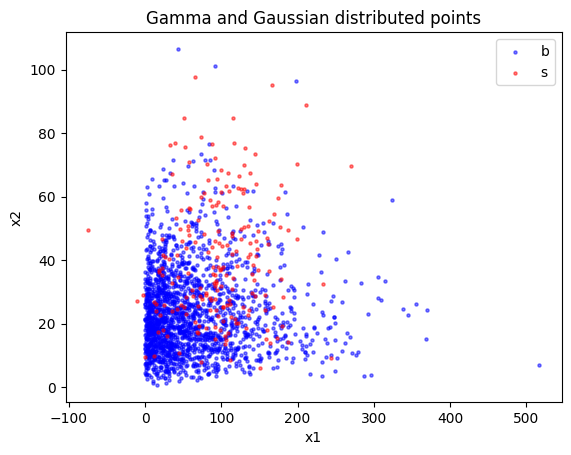

In [25]:
visualize_scatter_gamma(p)

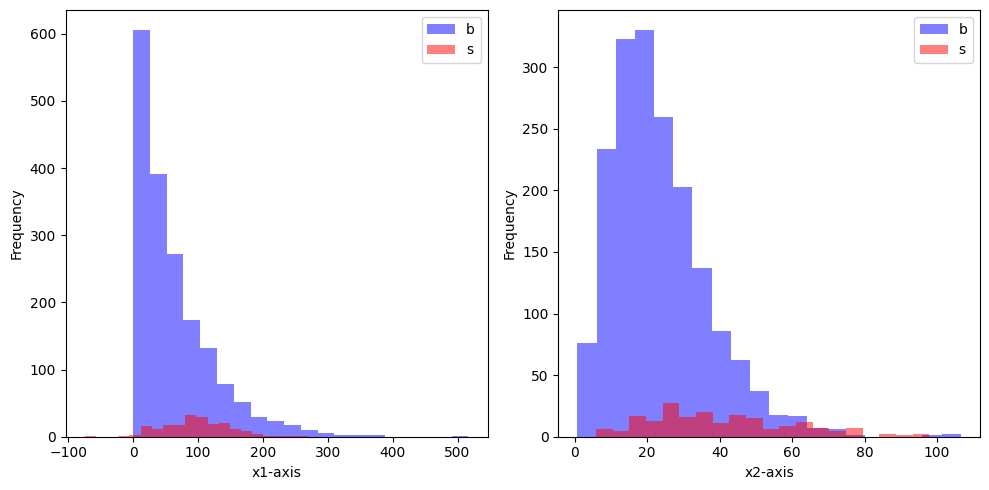

In [26]:
visualize_projected_histograms(p)

In [ ]:
".\Generated data\05-10\3\p0.5-bd1['Gamma', [2, 40]]-bd2['Gamma', [2, 18]]-sd1['Gaussian', [100, 10]]-sd2['Gamma', [3, 20]]\delta_k_1-1-delta_tau_120-delta_k_21-delta_tau_220\train\data\train_0.csv"